# Topic Modeling of Job Descriptions

### Purpose:
Our users have looked at the list of recommended jobs and often said things like, "I want to find jobs that are similar to this one.". They want the ability to explore other jobs and find the right fit for their career. We are exploring multiple routes to solve this user need. We hypothesize that by using Topic Modeling (LDA) on the job descriptions, we will be able to categorize jobs into buckets that represent similar opportunities as each other. "Jobs like this one" will probably have similar words used to describe the role and the required activities. 

**Experiment to Consider:**
I wonder if the company name for the job might bias some of the topics that are identified. There are some companies that have many jobs posted. We might want to consider removing the company name from the corpus before we apply LDA. 

### Other solutions to consider:
- 2d Projection of the embeddings: This has merit because it allows the user to see all jobs in one big view and allows them to explore all the opportunites. However, it is non-intuitive for non-technical users. We've recieved mixed feedback on the use of an embeddings map to service this need.  
- Semantic Search: This approach is interesting because it is likely the lowest LOE, but the major drawback is that we might just return jobs from the same company and might not serve the true need of the user. 
- Clustering Algorithms: Various clustering algorithms would allow us to see the grouping of different jobs based on reduced features from the original high dimension space. We have experimented with this by taking the 768 dimension embedding and applying PCA to reduce down to 250 dimensions. The key challenge with this approach is that PCA data is non-linear and most clustering algortithms assume linear relationships in the data. Also, we wouldn't know WHY the clusters are created. 

----



## About LDA:

At a high level: 
The user has to manually choose the number of topics that should be discovered in the training corpus. This should be driven by a combination of domain knowledge and also experimentation. 

LDA will parse all the documents at then determine which words are typically shown with high frequency for a given topic. 

We can then pass in a document and given the word distrubution, the model will tell us which topic this likely is associated with. 

- Assumptions of LDA for Topic Modeling:
    - Documents with similar topics use similar groups of words
    - Latent topics can then be found by search for groups of words that frequently occur together in the documents across the corpus. 

Mathmatically Speaking...
- Assumptions of LDA for Topic Modeling
    - Documents are probability distributions over latent topics
    - Topics themselves are probability distributions over words. 


We are NOT saying that Document 1 is an example Topic 1. Instead we are saying that there is a probability that Document 1 is an example of Topic 1 because it contains many words that are found in Topic 1. There is a greater probability that it is an example of Topic 1, but there is also a chance it could be another one of the given topics too, just a lower probability of this. 

LDA represents documents as mixtures of topics that spit out words with certain probabilities. 

-----

Now imagine that we have a set of documents

We've chosen some fixed number of K Topics to discover and want to use LDA to learn the topic representation of each document and the words associated with each document. 

Go through each document, and randomly assign each word in the document to one of the K Topics

This random assignment already gives you both topic representations of all the documents and word distrubtions of all the topics. (But please be aware... These initial random topics won't make any sense)

Now we iterate over each word in every document to improve these topics. 

For each word in each document and for each topic t we calcuate:
    p(word w | topic t) = "The porportion of assignments to topic t over all documents that come from this word w"

After repeating the previous step a large number of times, we eventually reach a roughly steady state where the assignments are acceptable. 

We end up with an output such as:
    - Document assigned to Topic #4
    - Most common words (highest probability) for Topic #4:
        [cat, vet, bird, dogs]
    - It is up to the user to intepret these topics



----

### Determining the right number of topics

This notebook will explore the implementation of the elbow method to find the right number of topics in the corpus. 

- Elbow Method (Coherence Score)
Similar to the elbow method in K-Means clustering, you can plot the coherence score against the number of topics and look for the point where the improvement starts to diminish.

Elbow Method is a heuristic used to determine the optimal number of clusters or topics in a model by plotting the coherence score against the number of topics and looking for an "elbow" point where the rate of improvement slows down.

Steps:

Train Multiple Models: Train LDA models with different numbers of topics.
Plot Coherence Scores: Plot the coherence scores for each model.
Identify Elbow Point: Look for the point where adding more topics results in diminishing improvements in coherence.
Visualization: The plot typically shows coherence score on the y-axis and the number of topics on the x-axis. The optimal number of topics is where the curve has a clear inflection point or "elbow."


### References 
https://www.youtube.com/watch?v=be7Xd2Ntai8


In [27]:
import os
import inspect
import json
import sys
import time
import logging
import uuid 
import pandas as pd
from dotenv import load_dotenv
from datetime import datetime
from pathlib import Path

from operation_battleship_common_utilities.JobPostingDao import JobPostingDao
from operation_battleship_common_utilities.CandidateRequirementsDao import CandidateRequirementsDao
from operation_battleship_common_utilities.JobResponsibilitiesDao import JobResponsibilitiesDao
from operation_battleship_common_utilities.JobSkillsDao import JobSkillsDao
from operation_battleship_common_utilities.JobKeyWordsDao import JobKeyWordsDao
from operation_battleship_common_utilities.JobTitleCategoryClassifier import JobTitleCategoryClassifier
from operation_battleship_common_utilities.FailureLogger import FailureLogger

from operation_battleship_common_utilities.NomicAICaller import NomicAICaller
from operation_battleship_common_utilities.OpenAICaller import OpenAICaller
from operation_battleship_common_utilities.PineConeDatabaseCaller import PineConeDatabaseCaller

load_dotenv()

True

### LDA Model per Job Category:

For best results, we believe an model for predicting the "Topic" of jobs should be done for each of the given Job Categories. Since finding Product Manager type jobs is our top imperitive, we will first train a model using this approach. 

We will iterate on future experiments for the other job categories. 

In [28]:
# Get the list of jobs from the database and print the columns in the DF.
jobPostingDao = JobPostingDao()
allJobsDf = jobPostingDao.getAllJobs()
columns = allJobsDf.columns
print(columns)

Index(['job_posting_id', 'company_id', 'posting_url', 'posting_source',
       'posting_source_id', 'job_title', 'full_posting_description',
       'job_description', 'is_ai', 'job_salary',
       'job_posting_company_information', 'job_posting_date',
       'job_insertion_date', 'job_last_collected_date', 'job_active',
       'salary_low', 'salary_midpoint', 'salary_high', 'city', 'state',
       'is_genai', 'job_skills', 'is_ai_justification', 'work_location_type',
       'job_category', 'kmeansclusterid', 'dbscanclusterid', 'opticsclusterid',
       'kmeansclustertopicname', 'dbscanclustertopicname',
       'opticsclustertopicname'],
      dtype='object')


In [29]:
# Only keep the Product Manager jobs
allJobsDf = allJobsDf[allJobsDf['job_category'] == 'Product_Management']
jobDescriptionDf = jobDescriptionDf.reset_index(drop=True)

In [30]:
# We only need the column that contains the job description. 
# We will take a short peek at the top records to see a snippet of the values
jobDescriptionDf = allJobsDf[['full_posting_description']]
jobDescriptionDf.head()


,full_posting_description
0,"At U.S. Bank, we’re on a journey to do our bes..."
1,Nisum is a leading global digital commerce fir...
3,Identity. It's what the brave new world of ent...
4,Identity. It's what the brave new world of ent...
5,"At U.S. Bank, we’re on a journey to do our bes..."


In [31]:
# We can see the whole description for one of the rows 
# We can also see the number of rows in the dataframe
#jobDescriptionDf['full_posting_description'][8]
len(jobDescriptionDf)

40448

In [32]:
# LDA for this notebook will be done using the SkLearn Library. 
# We will explore GenSim in another notebook
from sklearn.feature_extraction.text import CountVectorizer


In [33]:
# Max DF allows us to ignore certain terms that have really high document frequency. If Software or Product are found in 95% of the jobs, then that term would be excluded.  When max_df=0.9 that means we would discard words that appear in 90% of the documents. 
# Min DF allows us to set the minimum doc frequcny. If set to an integer value of 5, this would mean that a word would need to show up in at least 5 documents in order to be counted. 
# For both of these input parameters, you can pass in a ratio of less than 1 or even an integer that specifies a raw number of documents. 

cv = CountVectorizer(max_df=0.95, min_df=.15, stop_words='english')

In [34]:
dtm = cv.fit_transform(jobDescriptionDf['full_posting_description'])

In [35]:
dtm

<40448x499 sparse matrix of type '<class 'numpy.int64'>'
	with 6617230 stored elements in Compressed Sparse Row format>

In [36]:
# I don't know the correct number of topics, choosing a value for now and we will look for scientific approaches to this later. 
from sklearn.decomposition import LatentDirichletAllocation

totalTopics = 25
randomSeed = 42

lda = LatentDirichletAllocation(n_components=totalTopics, random_state=randomSeed)

In [37]:
lda.fit(dtm)

In [ ]:
# Explore the vocabulary of the words
# How many words are in the corpus? 
# What is the object type of the get feature names?

print( len(cv.get_feature_names_out()) )
print (type(cv.get_feature_names_out()) )
print (cv.get_feature_names_out()[55])



499
<class 'numpy.ndarray'>
candidate


In [ ]:
# Get the feature names
feature_names = cv.get_feature_names_out()

# Write the feature names to a file, each on a new line
with open('features.txt', 'w', encoding='utf-8') as f:
    for feature in feature_names:
        f.write(feature + '\n')

In [ ]:
# Grab the topics
print (len(lda.components_))
print (type(lda.components_))
print(lda.components_.shape)


25
<class 'numpy.ndarray'>
(25, 499)


In [ ]:
# Each row of lda.components represents a topic. Remember, there are K Topics (We set K to 25)
# Arg sort will give us the ranked order for each index value of the high probability words. 
# array([10, 200, 1]) would show:
# arraye([2, 0 , 1]) Array index 2 has the lowest value, index 0 has the second lowest value and index 1 has the this lowest value. 
singleTopic = lda.components_[0]
singleTopic.argsort()

array([184,  20, 414, 217, 331, 330, 487, 263, 368, 180, 219,  79, 410,
         0, 242, 253, 467, 153,  41, 154,  36, 139, 370, 172, 376, 314,
       293, 203, 347, 341, 393, 148, 295, 233, 493, 294,  16,  10,   2,
       351, 373,   3, 374, 329, 495, 271,  59, 354,   1, 170, 399, 126,
        65, 168, 210, 205, 138, 189,  99, 446, 225, 473, 252, 216,  71,
       344, 342, 105,  70, 137, 488,  30, 262, 214, 425, 343, 303, 240,
        14, 479,  58,  52,  72,  68, 469,  63, 277, 401, 206, 447, 352,
       359, 190,  22, 391, 350, 250, 362, 333, 194, 158, 463,  90, 209,
       199,  54,  21, 284, 221, 192, 136, 260, 433, 258, 149, 208, 279,
        48, 114, 397,  35, 417, 268, 451, 281, 419, 478, 245, 326, 377,
       247, 200, 482, 270, 159, 299, 229,  15, 336, 119, 361, 285, 380,
       456, 289, 238, 174, 300, 177, 383, 162, 176, 224, 288, 400, 280,
       442, 110, 338, 418, 195,  33, 434, 193, 257, 147, 246, 235, 120,
       182,  26, 207, 186, 259, 107, 131, 406,  51, 371, 234, 14

In [ ]:
# We can get the ten highest probability words for this topic:
# Reminder: Arg Sort --> Index Positions sorted from Least -> Greatest
# Starting at index postiion -10, go all the way to the end.
singleTopic.argsort()[-10:]




array([111, 365, 237, 497, 160, 457, 453, 415,  53, 455], dtype=int64)

In [ ]:
# Create an array of the words and then print the words
topWordsForTopic = singleTopic.argsort()[-25:]

for index in topWordsForTopic:
    print(cv.get_feature_names_out()[index])

provide
support
employment
key
role
time
owner
vision
new
drive
working
risk
position
status
design
customer
products
information
years
engineering
technology
teams
security
business
technical


In [ ]:
# Grab the highest probability words per topic

for i,topic in enumerate(lda.components_):
    print(f"The Top 15 words for topic #{i}]")
    print([cv.get_feature_names_out()[index] for index in topic.argsort()[-15:]])
    print("\n")
    print("\n")

The Top 15 words for topic #0]
['working', 'risk', 'position', 'status', 'design', 'customer', 'products', 'information', 'years', 'engineering', 'technology', 'teams', 'security', 'business', 'technical']




The Top 15 words for topic #1]
['technology', 'want', 'experiences', 'position', 'role', 'status', 'business', 'work', 'time', 'management', 'customer', 'new', 'customers', 'team', 'll']




The Top 15 words for topic #2]
['range', 'digital', 'people', 'including', 'global', 'inclusive', 'paid', 'learning', 'employees', 'team', 'benefits', 'skills', 'company', 'life', 'work']




The Top 15 words for topic #3]
['ensure', 'customer', 'vision', 'user', 'benefits', 'requirements', 'members', 'owner', 'delivery', 'value', 'backlog', 'work', 'agile', 'business', 'team']




The Top 15 words for topic #4]
['company', 'protected', 'plans', 'range', 'define', 'including', 'compensation', 'software', 'management', 'ability', 'skills', 'status', 'business', 'customer', 'market']




The To

In [ ]:
topicResults = lda.transform(dtm)

In [ ]:
# An array where each row is the job description and each column is a probability that the topic is represented in this document. 
print(topicResults.shape)

# For document at index 50, round to two decimal places to see the probability of the topic being represented
print(topicResults[50].round(2))

(40388, 25)
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.94
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.06 0.  ]


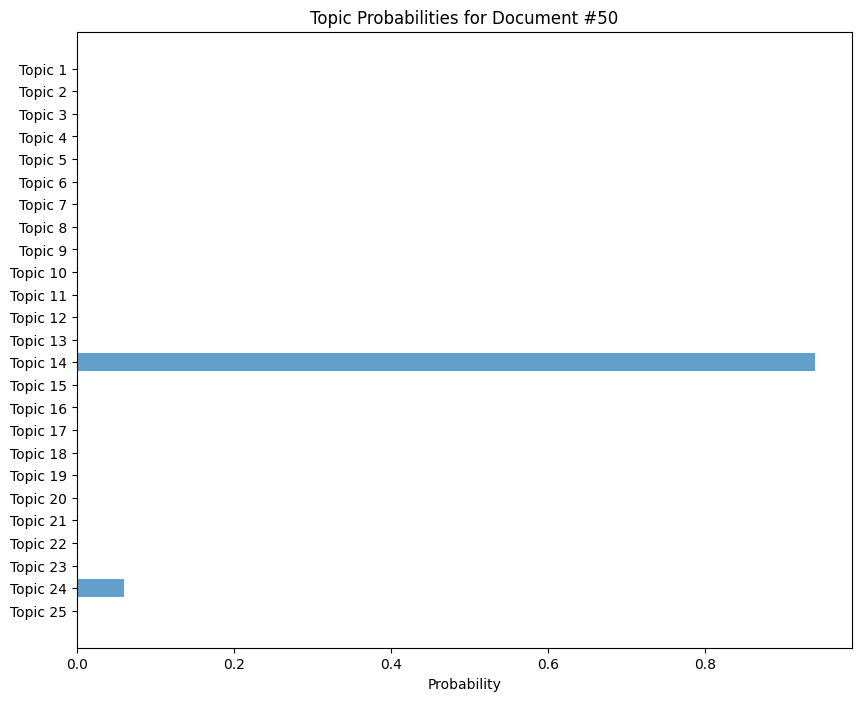

In [ ]:
#Lets see this in a visual representation now
import matplotlib.pyplot as plt
import numpy as np

# For document at index 50, round to two decimal places
topic_probs = topicResults[50].round(2)

# Number of topics (assuming you have 25 topics)
num_topics = len(topic_probs)

# Create a horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(np.arange(num_topics), topic_probs, align='center', alpha=0.7)
plt.yticks(np.arange(num_topics), [f'Topic {i+1}' for i in range(num_topics)])
plt.xlabel('Probability')
plt.title('Topic Probabilities for Document #50')
plt.gca().invert_yaxis()  # Invert y-axis to have topic 1 at the top
plt.show()

**Topic 13 Words**

The Top 15 words for topic #13]
['required', 'information', 'client', 'team', 'process', 'analysis', 'program', 'projects', 'requirements', 'skills', 'support', 'work', 'management', 'business', 'project']

In [26]:
# For the topic with this highest probability, we can look at the document and see what it says and get an intution for the topic itself. 
jobDescriptionDf['full_posting_description'][50]


KeyError: 50

In [41]:
# Run Argmax to just get the index position of the highest probability
# Note the offset value. We list 12 here, but the chart above shows 13 due to indexes starting at zero.  
print(topicResults[50].argmax())

12


In [43]:
# We can create a new column in the original datframe and apply the topic to the job posting
jobDescriptionDf.loc[:, "Topic"] = topicResults.argmax(axis=1)

In [46]:
print(jobDescriptionDf.columns)
print(jobDescriptionDf.shape)

Index(['full_posting_description', 'Topic'], dtype='object')
(69413, 2)


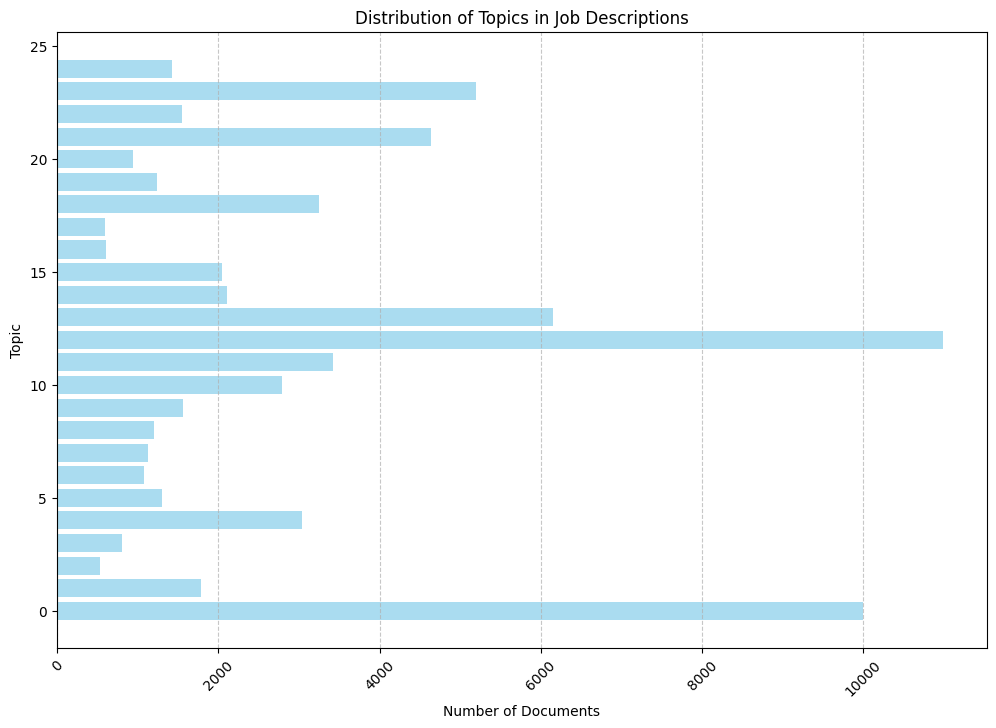

In [47]:
# We can explore the distribution of topics across the documents. 
# Step 1: Count the occurrences of each topic
topic_counts = jobDescriptionDf['Topic'].value_counts().sort_index()

# Step 2: Create the horizontal bar chart
plt.figure(figsize=(12, 8))
plt.barh(topic_counts.index, topic_counts.values, color='skyblue', alpha=0.7)
plt.xlabel('Number of Documents')
plt.ylabel('Topic')
plt.title('Distribution of Topics in Job Descriptions')
plt.xticks(rotation=45)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show the chart
plt.show()

In [51]:
# We can grab an example of each topic, using the most recent documents. 
# We will then build a prompt for Chat GPT and ask it to apply some possible labels to these topics. 


# Reverse the DataFrame to start from the last row
reversed_df = jobDescriptionDf.iloc[::-1]

# Extract one example row for each unique topic
example_rows = reversed_df.groupby('Topic').first().reset_index()

# Write the example rows to a file with utf-8 encoding
with open('topics.txt', 'w', encoding='utf-8') as file:
    for index, row in example_rows.iterrows():
        file.write(f"Topic: {row['Topic']}\n")
        file.write(f"Description: {row['full_posting_description']}\n")
        file.write("\n ######### \n")


In [53]:
# Maybe we want three example records for each topic

# Reverse the DataFrame to start from the last row
reversed_df = jobDescriptionDf.iloc[::-1]

# Extract three example rows for each unique topic
example_rows = reversed_df.groupby('Topic').head(3).reset_index(drop=True)

# Write the example rows to a file with utf-8 encoding
with open('topicsThreeJobDescriptions.txt', 'w', encoding='utf-8') as file:
    current_topic = None
    for index, row in example_rows.iterrows():
        if row['Topic'] != current_topic:
            if current_topic is not None:
                file.write("\n")
            current_topic = row['Topic']
            file.write(f"Topic: {current_topic}\n")
        file.write(f"Job Description {index % 3 + 1}: {row['full_posting_description']}\n #### \n")



In [57]:
import pandas as pd

# Assuming jobDescriptionDf is already created
# jobDescriptionDf = pd.read_csv('your_file.csv')  # Example to load DataFrame from a CSV

# Reverse the DataFrame to start from the last row
reversed_df = jobDescriptionDf.iloc[::-1]

# Extract the last three rows for each unique topic
example_rows = reversed_df.groupby('Topic').head(3)

# Write the example rows to a file with utf-8 encoding
with open('topicsThreeJobDescriptions.txt', 'w', encoding='utf-8') as file:
    for topic, group in example_rows.groupby('Topic'):
        file.write(f"Time for a new topic. \n Topic: {topic}\n")
        for index, row in group.iterrows():
            file.write(f"Job Description {index + 1}: \n {row['full_posting_description']}\n #### \n")
        file.write("\n")
